## Topic Modelling

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys
import os
#!{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint
import nltk

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
import gensim.utils
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

C:\Users\dvaro\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
### from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'could', 'also'])

## Loading data

In [5]:
df = pd.read_csv('transform_data.cv')
df = df.fillna("")
df.columns

Index(['id', 'type', 'text', 'created'], dtype='object')

In [6]:
data = list(df['text'])
len(data)

934

## Tokenizing and cleaning data

In [7]:
from gensim.utils import simple_preprocess
def clean_text(texts):
    for sent in texts:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

data_0  = list(clean_text(data))

## Bigrams-Trigrams Models

In [8]:
xx= pd.Series(nltk.ngrams(data_0, 1)).value_counts()
as_dataframe= xx.to_frame("count")
reqd_Index = as_dataframe[as_dataframe['count']<=100].index.tolist()
lowest_frequency_unigrams =[]
for element in reqd_Index:
    lowest_frequency_unigrams.append(element)
lowest_frequency_unigrams.append("1")
lowest_frequency_unigrams.append("\ufeff1")

print ("lowest_frequency_unigrams",len(lowest_frequency_unigrams))

data =[]
for text in data_0:
    temporal_variable=[]
    for word in text:
        if word not in lowest_frequency_unigrams:
            temporal_variable.append(word)
    temporal_variable= " ".join(temporal_variable)
    data.append(temporal_variable)
    
#12
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

lowest_frequency_unigrams 923
[['the', 'report', 'pdf', 'https', 'www', 'who', 'int', 'docs', 'default', 'source', 'coronaviruse', 'who', 'china', 'joint', 'mission', 'on', 'covid', 'final', 'report', 'pdf', 'wuhan', 'yeah', 'its', 'still', 'in', 'lockdown', 'my', 'take', 'is', 'that', 'they', 'need', 'intensive', 'care', 'to', 'make', 'patients', 'alive', 'and', 'recover', 'and', 'they', 'need', 'more', 'facilities', 'to', 'keep', 'motility', 'low', 'who', 'advisor', 'on', 'press', 'conference', 'was', 'saying', 'that', 'what', 'china', 'is', 'doing', 'while', 'the', 'lockdown', 'is', 'going', 'on', 'is', 'to', 'build', 'more', 'hospitals', 'and', 'containment', 'facilities', 'welp']]


In [9]:
bigram = gensim.models.Phrases(data_words, min_count=50, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['the', 'report', 'pdf_https_www', 'who', 'int', 'docs', 'default', 'source', 'coronaviruse', 'who', 'china', 'joint', 'mission', 'on', 'covid', 'final', 'report', 'pdf', 'wuhan', 'yeah', 'its', 'still', 'in', 'lockdown', 'my', 'take', 'is', 'that', 'they', 'need', 'intensive_care', 'to', 'make', 'patients', 'alive', 'and', 'recover', 'and', 'they', 'need', 'more', 'facilities', 'to', 'keep', 'motility', 'low', 'who', 'advisor', 'on', 'press', 'conference', 'was', 'saying', 'that', 'what', 'china', 'is', 'doing', 'while', 'the', 'lockdown', 'is', 'going', 'on', 'is', 'to', 'build', 'more', 'hospitals', 'and', 'containment', 'facilities', 'welp']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en

nlp = spacy.load("en_core_web_sm")


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['report', 'int', 'default', 'source', 'coronaviruse', 'mission', 'report', 'still', 'lockdown', 'take', 'need', 'intensive', 'care', 'make', 'patient', 'alive', 'recover', 'need', 'more', 'facility', 'keep', 'motility', 'low', 'advisor', 'press', 'conference', 'say', 'do', 'lockdown', 'go', 'build', 'more', 'hospital', 'containment', 'facility', 'welp']]


In [12]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=50, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['the', 'report', 'pdf_https_www', 'who', 'int', 'docs', 'default', 'source', 'coronaviruse', 'who', 'china', 'joint', 'mission', 'on', 'covid', 'final', 'report', 'pdf', 'wuhan', 'yeah', 'its', 'still', 'in', 'lockdown', 'my', 'take', 'is', 'that', 'they', 'need', 'intensive_care', 'to', 'make', 'patients', 'alive', 'and', 'recover', 'and', 'they', 'need', 'more', 'facilities', 'to', 'keep', 'motility', 'low', 'who', 'advisor', 'on', 'press', 'conference', 'was', 'saying', 'that', 'what', 'china', 'is', 'doing', 'while', 'the', 'lockdown', 'is', 'going', 'on', 'is', 'to', 'build', 'more', 'hospitals', 'and', 'containment', 'facilities', 'welp']


In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1)]]


In [14]:
#12.0
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [15]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

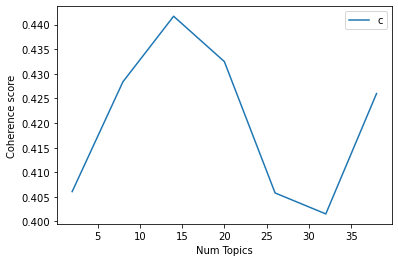

In [16]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [17]:
for m, cv in zip (x,coherence_values):
    print ("num topics= ", m, "has Coherence Value of", round (cv,4))

num topics=  2 has Coherence Value of 0.4061
num topics=  8 has Coherence Value of 0.4284
num topics=  14 has Coherence Value of 0.4417
num topics=  20 has Coherence Value of 0.4325
num topics=  26 has Coherence Value of 0.4058
num topics=  32 has Coherence Value of 0.4015
num topics=  38 has Coherence Value of 0.426


In [18]:
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(0, '0.076*"death" + 0.037*"covid" + 0.027*"lockdown" + 0.022*"mortality" + 0.020*"year" + 0.018*"cause" + 0.018*"excess" + 0.015*"impact" + 0.013*"health" + 0.013*"care"'), (1, '0.025*"people" + 0.014*"so" + 0.014*"go" + 0.012*"more" + 0.012*"think" + 0.011*"just" + 0.011*"be" + 0.010*"say" + 0.010*"how" + 0.010*"see"'), (2, '0.026*"variant" + 0.019*"cohort" + 0.016*"com" + 0.014*"patient" + 0.011*"introduction" + 0.010*"acute" + 0.010*"severe" + 0.010*"article" + 0.009*"individual" + 0.009*"clinical"'), (3, '0.021*"test" + 0.015*"infection" + 0.014*"prevalence" + 0.014*"study" + 0.014*"case" + 0.014*"positive" + 0.013*"child" + 0.012*"contact" + 0.010*"result" + 0.010*"transmission"'), (4, '0.043*"mask" + 0.043*"yoga" + 0.027*"minute" + 0.026*"rat" + 0.021*"bodsphere" + 0.020*"wear" + 0.017*"behavior" + 0.015*"pcr" + 0.012*"correlate" + 0.009*"pest"'), (5, '0.024*"lockdown" + 0.018*"country" + 0.009*"measure" + 0.009*"datum" + 0.009*"more" + 0.008*"number" + 0.008*"rate" + 0.008*"ef

In [19]:
print(optimal_model.print_topics())
doc_lda = optimal_model[corpus]

[(0, '0.076*"death" + 0.037*"covid" + 0.027*"lockdown" + 0.022*"mortality" + 0.020*"year" + 0.018*"cause" + 0.018*"excess" + 0.015*"impact" + 0.013*"health" + 0.013*"care"'), (1, '0.025*"people" + 0.014*"so" + 0.014*"go" + 0.012*"more" + 0.012*"think" + 0.011*"just" + 0.011*"be" + 0.010*"say" + 0.010*"how" + 0.010*"see"'), (2, '0.026*"variant" + 0.019*"cohort" + 0.016*"com" + 0.014*"patient" + 0.011*"introduction" + 0.010*"acute" + 0.010*"severe" + 0.010*"article" + 0.009*"individual" + 0.009*"clinical"'), (3, '0.021*"test" + 0.015*"infection" + 0.014*"prevalence" + 0.014*"study" + 0.014*"case" + 0.014*"positive" + 0.013*"child" + 0.012*"contact" + 0.010*"result" + 0.010*"transmission"'), (4, '0.043*"mask" + 0.043*"yoga" + 0.027*"minute" + 0.026*"rat" + 0.021*"bodsphere" + 0.020*"wear" + 0.017*"behavior" + 0.015*"pcr" + 0.012*"correlate" + 0.009*"pest"'), (5, '0.024*"lockdown" + 0.018*"country" + 0.009*"measure" + 0.009*"datum" + 0.009*"more" + 0.008*"number" + 0.008*"rate" + 0.008*"ef

In [20]:
pyLDAvis.enable_notebook()
import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word,mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.057447  0.355851       1        1  27.132580
5     -0.283691  0.099174       2        1  26.958794
6     -0.066101  0.162474       3        1  16.894713
3      0.291895  0.164139       4        1  14.187395
0     -0.275895 -0.184044       5        1  11.113690
2      0.183998 -0.270598       6        1   2.052610
4      0.180344 -0.110070       7        1   0.949736
7      0.026896 -0.216925       8        1   0.710482, topic_info=           Term         Freq        Total Category  logprob  loglift
158       death   832.000000   832.000000  Default  30.0000  30.0000
35        covid   957.000000   957.000000  Default  29.0000  29.0000
15     lockdown  1407.000000  1407.000000  Default  28.0000  28.0000
65         case   644.000000   644.000000  Default  27.0000  27.0000
151     country   427.000000   427.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
3519      storm     1.510842     2.456598   Topic8  -6.0407   4.4609
2242   virulent     1.494664     2.437825   Topic8  -6.0515   4.4578
1330  neighbour     1.473142     2.418918   Topic8  -6.0660   4.4511
6464    midland     2.520649     5.548639   Topic8  -5.5289   4.1579
2899  dangerous     2.402365    23.245594   Topic8  -5.5769   2.6773

[465 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1611      5  0.977283  accident
1103      3  0.981668    active
842       2  0.283193  activity
842       5  0.699654  activity
843       1  0.989711  actually
...     ...       ...       ...
295       3  0.003308      year
295       4  0.135640      year
295       5  0.674891      year
6834      7  0.972222      yoga
4477      6  0.918655      zinc

[757 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 7, 4, 1, 3, 5, 8])

In [21]:
#12.6 Select the model and print the topics
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(32, '0.000*"superior" + 0.000*"sane" + 0.000*"profitable" + 0.000*"scaledown" + 0.000*"sickday" + 0.000*"ball" + 0.000*"suspension" + 0.000*"regimen" + 0.000*"nightmare" + 0.000*"tank"'), (13, '0.000*"superior" + 0.000*"sane" + 0.000*"profitable" + 0.000*"scaledown" + 0.000*"sickday" + 0.000*"ball" + 0.000*"suspension" + 0.000*"regimen" + 0.000*"nightmare" + 0.000*"tank"'), (34, '0.012*"objectively" + 0.000*"sane" + 0.000*"sickday" + 0.000*"superior" + 0.000*"suspension" + 0.000*"profitable" + 0.000*"private" + 0.000*"vastly" + 0.000*"regimen" + 0.000*"debatable"'), (30, '0.018*"web" + 0.000*"private" + 0.000*"sickday" + 0.000*"superior" + 0.000*"suspension" + 0.000*"sane" + 0.000*"profitable" + 0.000*"vastly" + 0.000*"regimen" + 0.000*"ball"'), (37, '0.021*"speculate" + 0.005*"spending" + 0.000*"reduction" + 0.000*"suspension" + 0.000*"private" + 0.000*"sickday" + 0.000*"superior" + 0.000*"wastewater" + 0.000*"sane" + 0.000*"profitable"'), (17, '0.040*"danger" + 0.015*"furlough" + 0